In [1]:
tooth007 = 'https://osf.io/7trgk/download'

In [2]:
tooth045 = 'https://osf.io/fqm4x/download'

In [3]:
import os
import requests
from tqdm import notebook

In [4]:
Root = 'data'
os.makedirs(Root, exist_ok=True)

In [5]:
if os.path.exists(os.path.join(Root, '7.zip')):
    print('File already downloaded')
else:
    # Progress bar for download via https://stackoverflow.com/a/44920494/323100
    download = requests.get(tooth007, stream=True)
    totalsize = int(download.headers["Content-Length"])
    chunksize = 1024 * 1024
    bars = int(totalsize / chunksize)
    with open(os.path.join(Root, '7.zip'), "wb") as f:
        for chunk in notebook.tqdm(download.iter_content(chunk_size=chunksize),
                                   total=bars,
                                   unit="MB",
                                   desc='Downloading 7.zip (%s GB)' % round(totalsize * 1e-9,1)):        
            f.write(chunk)

File already downloaded


In [6]:
if os.path.exists(os.path.join(Root, '45.zip')):
    print('File already downloaded')
else:    
    # Progress bar for download via https://stackoverflow.com/a/44920494/323100
    download = requests.get(tooth045, stream=True)
    totalsize = int(download.headers["Content-Length"])
    chunksize = 1024 * 1024
    bars = int(totalsize / chunksize)
    with open(os.path.join(Root, '45.zip'), "wb") as f:
        for chunk in notebook.tqdm(download.iter_content(chunk_size=chunksize),
                                   total=bars,
                                   unit="MB",
                                   desc='Downloading 45.zip (%s GB)' % round(totalsize * 1e-9,1)):        
            f.write(chunk)

File already downloaded


In [7]:
import glob
import zipfile

In [8]:
ziplist = glob.glob(os.path.join(Root, '*.zip'))
for file in notebook.tqdm(ziplist,
                          total=len(ziplist),
                          desc='Unzipping %s files' % len(ziplist)):
    with zipfile.ZipFile(file, 'r') as zip_file:
        for file in notebook.tqdm(iterable=zip_file.namelist(),
                                  desc=file,
                                  total=len(zip_file.namelist()),
                                  leave=False):
            if not os.path.exists(os.path.join(Root, file)):
                zip_file.extract(member=file, path=Root)

In [9]:
import pandas

In [10]:
Data = pandas.DataFrame()

In [11]:
import glob

In [12]:
Data['Folder'] = glob.glob(os.path.join('data', '*' + os.path.sep))

In [13]:
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, '*.log')))[0] for f in Data['Folder']]
print('We have %s tooth samples to work with' % (len(Data)))

We have 2 tooth samples to work with


In [14]:
Data['Sample'] = [os.path.splitext(os.path.basename(l))[0] for l in Data['LogFile']]

In [15]:
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f,
                                                         'rec',
                                                         '*rec*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [16]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [17]:
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [18]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
if len(Data['Voxelsize'].round(2).unique()) > 1:
    print('We scanned the teeht with %s different voxel sizes' % len(Data['Voxelsize'].round(2).unique()))
    for vs in sorted(Data['Voxelsize'].round(2).unique()):
        print('-', vs, 'um for Samples ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], 2):
                print(row.Sample, end=', ')
        print('')
else:
    print('We scanned all %s datasets with equal voxel size, namely %s.' % (len(Data),
                                                                            Data['Voxelsize'].unique()[0]))

We scanned all 2 datasets with equal voxel size, namely 9.999986.


In [19]:
import imageio
import numpy

In [20]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

In [21]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [22]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to P:\Documents\ZMK\Output\afc9e38


In [23]:
lines = 1

In [24]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

In [25]:
# Set up figure defaults
# Display all images in b&w and with 'nearest' interpolation
plt.rc('image', cmap='gray', interpolation='nearest')
# Resize figures
plt.rcParams['figure.figsize'] = (16, 9)

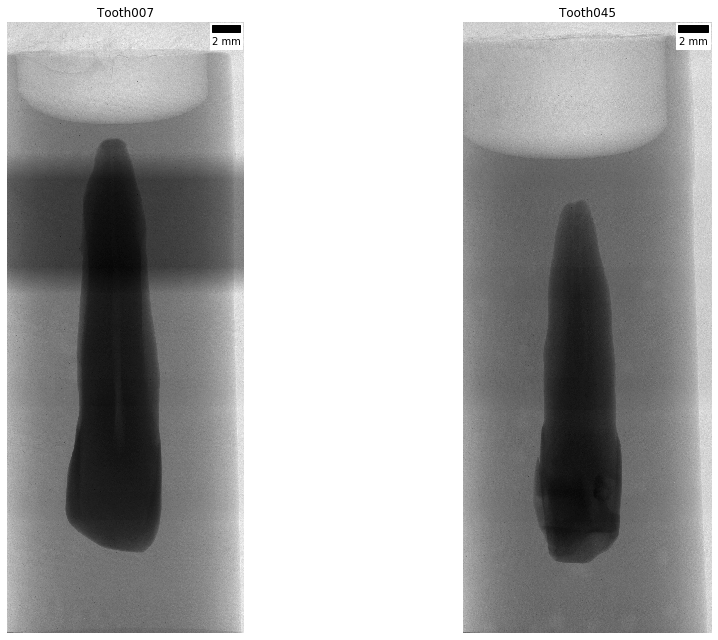

In [26]:
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='black'))
    plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig(os.path.join(OutPutDir, 'ScanOverviews.png'),
            bbox_inches='tight')
plt.show()

In [27]:
import dask_image.imread
from numcodecs import Blosc

In [28]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%3s/%3s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], 'rec', '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [29]:
import dask

In [30]:
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [31]:
Data['Size'] = [rec.shape for rec in Reconstructions]

In [32]:
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [33]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [35]:
import seaborn

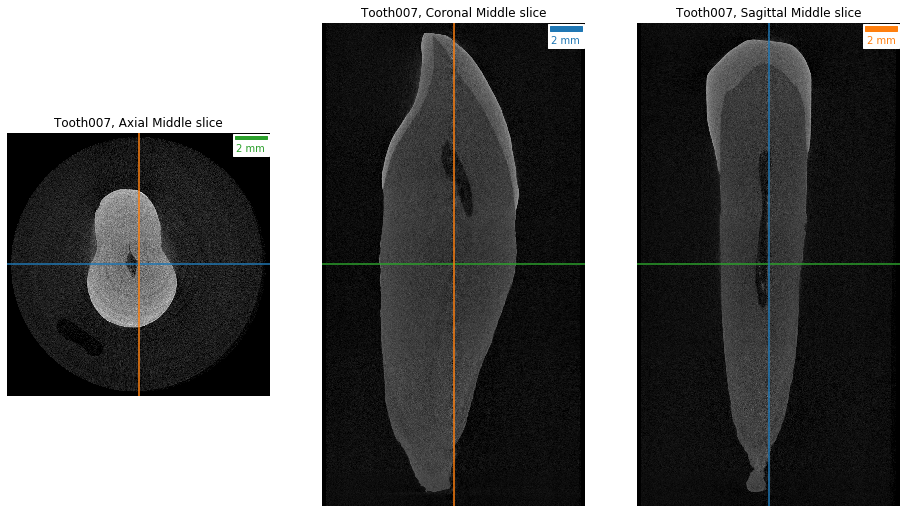

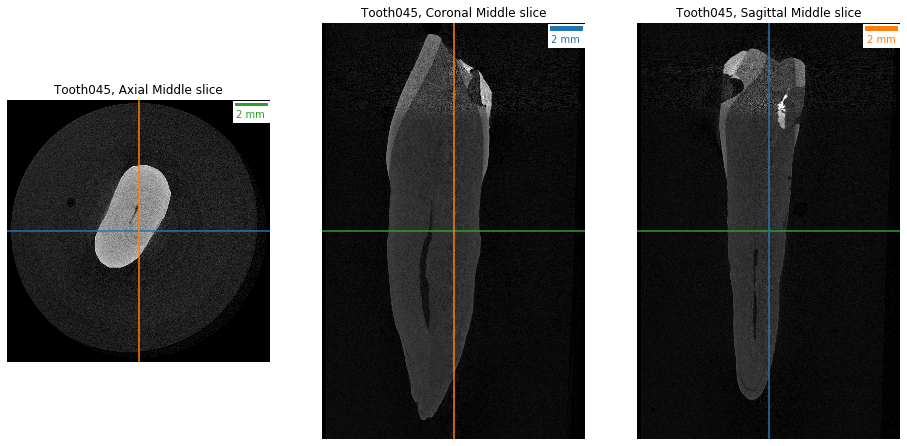

In [36]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_' + direction])
            if d == 0:
                plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
            else:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' Middle slice'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [37]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

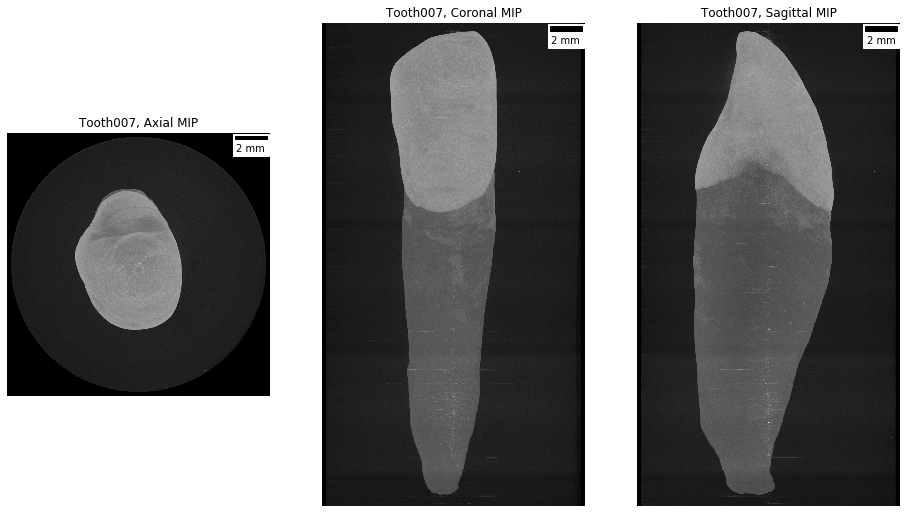

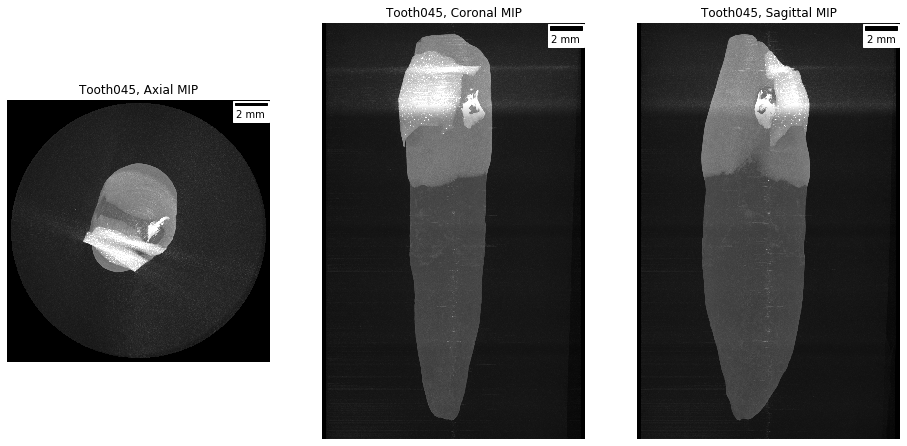

In [38]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MIPs.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()